Dataset Source = https://huggingface.co/datasets/xlangai/spider

This Script is for **training** , It loads the dataset into inputs and uses Hardcoded schema , Model is thrained using above Datset

In [ ]:
#!pip install datasets

from datasets import load_dataset
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
import torch

# Load your dataset (using xlangai/spider dataset)
dataset = load_dataset("xlangai/spider")

# Hardcode the schema you want the model to always use
static_schema = "employees(employee_id, name, department, position, salary, bike_owned)"

# Add the static schema to all questions in the dataset
def preprocess_function(examples):
    questions = examples['question']
    sql_queries = examples['query']

    # Prepend schema to every question
    questions_with_schema = [f"Schema: {static_schema}. Question: {question}" for question in questions]

    return {
        'input_text': questions_with_schema,
        'target_text': sql_queries
    }

# Apply the preprocessing function to the dataset
tokenized_dataset = dataset.map(preprocess_function, batched=True)

# Load the tokenizer and model
model = T5ForConditionalGeneration.from_pretrained("t5-base")
tokenizer = T5Tokenizer.from_pretrained("t5-base")

# Tokenize the input and target text
def tokenize_function(examples):
    inputs = tokenizer(examples['input_text'], max_length=512, truncation=True, padding="max_length")
    targets = tokenizer(examples['target_text'], max_length=512, truncation=True, padding="max_length")

    # Create the labels key with the target tokenized data
    inputs['labels'] = targets['input_ids']

    # Return necessary tensor keys for training
    return {
        'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
        'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
        'labels': torch.tensor(inputs['labels'], dtype=torch.long)
    }

# Tokenize the entire dataset
tokenized_dataset = tokenized_dataset.map(tokenize_function, batched=True, remove_columns=dataset['train'].column_names)

# Split into training and validation sets if needed
if 'validation' not in tokenized_dataset:
    tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.1)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./my_static_schema_t5_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
)

# Fine-tune the model
trainer.train()

# Save the fine-tuned model
trainer.save_model("./MySQL_t5_model")


Further it creates a New model named **MySQL_t5_model**

______________________________________________________________________________________

The following script is to test the model using user queries

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load the custom fine-tuned model and tokenizer
model_path = "./MySQL_t5_model"  # Path where your model is saved
model = T5ForConditionalGeneration.from_pretrained(model_path)
tokenizer = T5Tokenizer.from_pretrained(model_path)

# Function to generate SQL query from a question, considering the schema
def generate_sql_query(schema, question):
    # Combine schema and question with a clearer prompt
    input_text = f"Translate English to SQL based on the provided schema:\nSchema: {schema}\nQuestion: {question}"

    # Preprocess the input question
    inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)

    # Generate the output (SQL query)
    outputs = model.generate(inputs, max_length=150, num_beams=5, early_stopping=True)

    # Decode the output and return the SQL query
    sql_query = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return sql_query

# Example interaction with schema and question input
while True:
    # Get the schema input from the user
    schema = input("Enter the table schema (or type 'exit' to quit): ")
    if schema.lower() == "exit":
        break

    # Get the natural language question
    question = input("Enter a question in natural language (or type 'exit' to quit): ")
    if question.lower() == "exit":
        break

    # Generate the SQL query based on the schema and question
    sql_query = generate_sql_query(schema, question)
    print(f"Generated SQL Query: {sql_query}")


Problems: Hardware Bottle neck




**OutOfMemoryError:** CUDA out of memory. Tried to allocate 96.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 31.06 MiB is free. Process 3260 has 14.71 GiB memory in use. Of the allocated memory 14.49 GiB is allocated by PyTorch, and 99.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

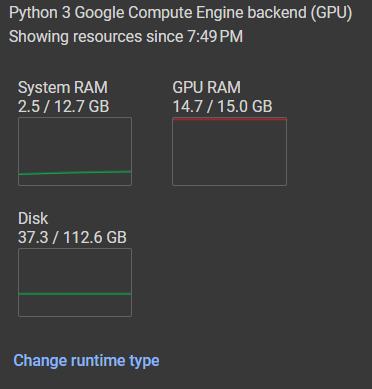